In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,772 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [3]:
# Install necessary libraries
!pip install ultralytics opencv-python-headless lxml tqdm albumentations pytesseract

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 25.0 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:
# Import libraries
import os
import cv2
import glob
import shutil
import yaml
import pytesseract
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from matplotlib import pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Define paths
images_path = "/content/drive/MyDrive/Colab Datasets/archive/images/"
annotations_path = "/content/drive/MyDrive/Colab Datasets/archive/annotations/"
dataset_path = "/content/dataset/"
resized_images_path = "/content/resized_images/"


In [6]:

# Helper function to resize images
def resize_images(input_dir, output_dir, size=(640, 640)):
    os.makedirs(output_dir, exist_ok=True)
    for img_file in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            resized_img = cv2.resize(img, size)
            cv2.imwrite(os.path.join(output_dir, img_file), resized_img)

# Resize the images
resize_images(images_path, resized_images_path, size=(640, 640))

# Create dataset directories
os.makedirs(f"{dataset_path}train/images", exist_ok=True)
os.makedirs(f"{dataset_path}train/labels", exist_ok=True)
os.makedirs(f"{dataset_path}val/images", exist_ok=True)
os.makedirs(f"{dataset_path}val/labels", exist_ok=True)

In [7]:

# Helper function to convert XML annotations to YOLO format
def convert_annotation(xml_file, output_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_width = int(root.find("size/width").text)
    image_height = int(root.find("size/height").text)

    yolo_annotations = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bbox = obj.find("bndbox")
        x_min = int(bbox.find("xmin").text)
        y_min = int(bbox.find("ymin").text)
        x_max = int(bbox.find("xmax").text)
        y_max = int(bbox.find("ymax").text)

        x_center = ((x_min + x_max) / 2) / image_width
        y_center = ((y_min + y_max) / 2) / image_height
        bbox_width = (x_max - x_min) / image_width
        bbox_height = (y_max - y_min) / image_height

        # Assuming a single class (license plate), class ID is 0
        yolo_annotations.append(f"0 {x_center} {y_center} {bbox_width} {bbox_height}\n")

    with open(output_path, "w") as file:
        file.writelines(yolo_annotations)

In [8]:

# Organize dataset and convert annotations
all_images = glob.glob(os.path.join(resized_images_path, "*.jp*g")) + glob.glob(os.path.join(resized_images_path, "*.png"))
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

def process_images(image_list, split):
    for image_path in image_list:
        image_name = os.path.basename(image_path)
        xml_file = os.path.join(annotations_path, image_name.replace(".png", ".xml"))
        label_output = os.path.join(dataset_path, f"{split}/labels", image_name.replace(".png", ".txt"))

        if os.path.exists(xml_file):
            shutil.copy(image_path, os.path.join(dataset_path, f"{split}/images", image_name))
            convert_annotation(xml_file, label_output)

In [9]:

# Process train and validation images
process_images(train_images, "train")
process_images(val_images, "val")

# Create a YAML configuration file
data_yaml = {
    'train': f"{dataset_path}train/images",
    'val': f"{dataset_path}val/images",
    'nc': 1,
    'names': ['license_plate']
}

In [10]:

with open("data.yaml", "w") as file:
    yaml.dump(data_yaml, file)

# Load YOLOv8 model
model = YOLO('yolov8m.pt')  # Use 'yolov8n.pt', 'yolov8m.pt', or 'yolov8l.pt'

# Train the YOLOv8 model
model.train(
    data="data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    name="alpr_model_optimized",
    augment=True,
    lr0=0.01,  # Initial learning rate
    lrf=0.1    # Final learning rate multiplier
)


100%|██████████| 49.7M/49.7M [00:00<00:00, 127MB/s]


Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=alpr_model_optimized, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 21.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 89.4MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<00:00, 579.17it/s]

train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/val/labels... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 240.26it/s]

val: New cache created: /content/dataset/val/labels.cache


Plotting labels to runs/detect/alpr_model_optimized/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/alpr_model_optimized
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.8G      1.601      3.204      1.454         20        640: 100%|██████████| 22/22 [00:14<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         87         89      0.716      0.596      0.613      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.81G      1.567      1.682      1.426         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         87         89    0.00146       0.18   0.000875   0.000404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.82G      1.629      1.539      1.466         22        640: 100%|██████████| 22/22 [00:11<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         87         89   0.000915      0.213   0.000622   0.000153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.77G      1.718      1.678      1.565         10        640: 100%|██████████| 22/22 [00:11<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         87         89   0.000915      0.213   0.000622   0.000153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.78G      1.752      1.549      1.542         16        640: 100%|██████████| 22/22 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         87         89   0.000599     0.0562    0.00031   0.000139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.83G      1.751      1.627       1.62         13        640: 100%|██████████| 22/22 [00:12<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         89   0.000599     0.0562    0.00031   0.000139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.74G      1.776       1.61      1.653         13        640: 100%|██████████| 22/22 [00:11<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         87         89    0.00113     0.0225   0.000595   0.000235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.83G      1.692      1.427      1.564         30        640: 100%|██████████| 22/22 [00:11<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         87         89      0.614      0.196      0.221      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.78G      1.636      1.244      1.532         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         87         89      0.745      0.416      0.476      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.83G      1.625      1.315      1.507         13        640: 100%|██████████| 22/22 [00:12<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         87         89      0.745      0.416      0.476      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.73G      1.622      1.349      1.536         20        640: 100%|██████████| 22/22 [00:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         87         89       0.89     0.0112     0.0154    0.00633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.83G      1.598       1.21      1.493         13        640: 100%|██████████| 22/22 [00:11<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         87         89      0.386      0.404      0.283      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.75G      1.559      1.202      1.458         13        640: 100%|██████████| 22/22 [00:11<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         87         89      0.761      0.629      0.682       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.83G      1.547      1.194      1.499         15        640: 100%|██████████| 22/22 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         87         89      0.675      0.438      0.511      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.74G      1.514      1.148      1.442         13        640: 100%|██████████| 22/22 [00:12<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         87         89      0.644      0.494      0.564      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.83G      1.521      1.162       1.43         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         87         89       0.72      0.831      0.851      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.77G      1.548      1.092      1.438         22        640: 100%|██████████| 22/22 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         87         89      0.911       0.69      0.864      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.82G      1.508      1.111      1.452         16        640: 100%|██████████| 22/22 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         87         89      0.823      0.782      0.868      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.77G      1.509      1.112      1.447         17        640: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         87         89      0.874      0.652      0.812      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.83G      1.465       1.05      1.411         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         87         89      0.795      0.787       0.86      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.79G        1.5      1.028      1.413         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         87         89      0.726      0.798      0.849      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.82G      1.456      1.102      1.446         13        640: 100%|██████████| 22/22 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         87         89      0.851      0.663      0.812      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.74G      1.401      1.012      1.363         22        640: 100%|██████████| 22/22 [00:12<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         87         89      0.855      0.665      0.764      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.84G      1.345      0.982      1.352         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         87         89      0.856       0.82      0.893      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.78G      1.499      1.031      1.432         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         87         89      0.854      0.787      0.878      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.83G       1.43      1.007      1.384         16        640: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         87         89      0.817      0.753       0.84      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.73G      1.397     0.9944      1.393         17        640: 100%|██████████| 22/22 [00:12<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         87         89      0.843      0.787      0.866      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.83G      1.351     0.9311      1.329         14        640: 100%|██████████| 22/22 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         87         89       0.89      0.719      0.869      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.74G      1.394     0.9618      1.394         13        640: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         87         89      0.814      0.775      0.874      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.85G      1.397     0.9547      1.353         16        640: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         87         89      0.874      0.787      0.889      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.76G      1.391     0.9627      1.359         15        640: 100%|██████████| 22/22 [00:12<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         87         89      0.751      0.742       0.81      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.83G      1.339     0.9076      1.356         19        640: 100%|██████████| 22/22 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         87         89      0.856      0.764      0.856      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.77G      1.366     0.9191      1.343         16        640: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         87         89      0.919      0.768      0.889      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.82G      1.333     0.8692      1.335         16        640: 100%|██████████| 22/22 [00:11<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         87         89      0.904      0.787      0.877      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.78G      1.331     0.8638      1.341         16        640: 100%|██████████| 22/22 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         87         89      0.836      0.744      0.865      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.82G      1.346     0.8942      1.296         17        640: 100%|██████████| 22/22 [00:12<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         87         89      0.818      0.843      0.898      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.74G      1.351      0.889      1.349         18        640: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         87         89      0.891      0.843      0.907      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.83G      1.298     0.8509       1.28         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         87         89       0.88      0.831      0.901      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.78G      1.274     0.8524      1.311         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         87         89      0.795      0.921      0.912      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.84G      1.292     0.8682      1.302         16        640: 100%|██████████| 22/22 [00:12<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         87         89      0.764      0.839      0.877      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.79G      1.313      0.869      1.315          9        640: 100%|██████████| 22/22 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         87         89      0.789      0.842      0.879      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.83G      1.378     0.8658      1.376         22        640: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         87         89      0.869      0.817      0.884      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.78G      1.322     0.8314      1.338         15        640: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         87         89      0.789      0.809      0.859      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.82G      1.283     0.8174      1.299         28        640: 100%|██████████| 22/22 [00:12<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         87         89      0.847      0.843      0.901       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.74G      1.234     0.7645      1.266         15        640: 100%|██████████| 22/22 [00:12<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         87         89      0.813      0.832      0.862      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.82G      1.269     0.7811      1.301         14        640: 100%|██████████| 22/22 [00:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         89      0.838      0.812      0.904      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.73G      1.215     0.7889      1.254         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         87         89      0.892      0.835      0.919      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.83G      1.308     0.8328      1.335         18        640: 100%|██████████| 22/22 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         87         89      0.822      0.832      0.903      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.8G      1.281     0.7963      1.301         18        640: 100%|██████████| 22/22 [00:12<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         87         89      0.837       0.81      0.877      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.82G      1.286     0.8219      1.296         12        640: 100%|██████████| 22/22 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         87         89      0.887       0.82      0.893      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.78G      1.202     0.7942      1.262         22        640: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         87         89      0.809       0.91      0.916      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.82G       1.26     0.7709       1.29         20        640: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         87         89      0.887       0.82      0.902      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.78G      1.172     0.6996      1.239         19        640: 100%|██████████| 22/22 [00:12<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         87         89      0.843      0.921      0.909      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.83G      1.131     0.7468      1.221         17        640: 100%|██████████| 22/22 [00:12<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         87         89      0.905      0.859      0.912      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.77G      1.175     0.7493      1.217          9        640: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         87         89      0.824      0.888      0.916      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.84G      1.188     0.7272      1.253         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         87         89      0.887       0.88      0.919      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.79G      1.177     0.7399       1.26         17        640: 100%|██████████| 22/22 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         87         89      0.897      0.854      0.928      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.83G       1.17     0.7427      1.238         22        640: 100%|██████████| 22/22 [00:12<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         87         89      0.893       0.82       0.92      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.78G      1.139     0.7095      1.244         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         89      0.923      0.843      0.918      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.82G      1.143     0.6918      1.235         15        640: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         87         89      0.882      0.839      0.913      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.74G      1.077     0.6631      1.205         15        640: 100%|██████████| 22/22 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         87         89      0.873      0.849        0.9      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.82G      1.157     0.7019      1.225         15        640: 100%|██████████| 22/22 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         87         89      0.813      0.876      0.901       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.77G       1.14     0.7165      1.232         14        640: 100%|██████████| 22/22 [00:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         87         89      0.807      0.876      0.859      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.84G      1.145     0.6844      1.218         13        640: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         87         89      0.858      0.812      0.902      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.77G      1.167     0.6978      1.231         14        640: 100%|██████████| 22/22 [00:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         87         89      0.855      0.858      0.911      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.82G      1.112     0.6778      1.211         30        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         87         89      0.865      0.864      0.874      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.73G      1.128     0.6783      1.241         18        640: 100%|██████████| 22/22 [00:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         87         89       0.86      0.854       0.92      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.83G      1.134     0.6761      1.223         12        640: 100%|██████████| 22/22 [00:11<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         87         89      0.823       0.91       0.93       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       6.8G      1.069     0.6606      1.178         24        640: 100%|██████████| 22/22 [00:11<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         87         89      0.872      0.845      0.927      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.83G      1.062     0.6468        1.2         17        640: 100%|██████████| 22/22 [00:12<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         87         89      0.803      0.822      0.884      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.78G      1.143     0.6752      1.224         12        640: 100%|██████████| 22/22 [00:12<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         87         89      0.797      0.839      0.884      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.82G      1.102     0.6511      1.212         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         87         89      0.776      0.895      0.913       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.77G      1.109     0.6592      1.218         18        640: 100%|██████████| 22/22 [00:11<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         87         89      0.926      0.809      0.921      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.84G      1.041     0.6371      1.198         18        640: 100%|██████████| 22/22 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         87         89       0.88      0.824      0.911      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.78G      1.089     0.6297      1.196         16        640: 100%|██████████| 22/22 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         87         89      0.877      0.843      0.914      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.83G      1.071     0.6266       1.19         20        640: 100%|██████████| 22/22 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         89       0.88      0.809      0.903      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.74G      1.038     0.6201      1.162         20        640: 100%|██████████| 22/22 [00:11<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         87         89      0.835      0.853      0.906      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.82G      1.051     0.6031      1.183         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         87         89      0.885      0.843      0.915      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.77G      1.056     0.6292      1.149         12        640: 100%|██████████| 22/22 [00:12<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         87         89      0.822      0.843      0.897      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.82G     0.9973     0.6162      1.152         16        640: 100%|██████████| 22/22 [00:12<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         87         89      0.801      0.904      0.919      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.78G      1.042     0.6039      1.167         20        640: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         87         89      0.825      0.902      0.911      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.83G     0.9813     0.5933      1.128         18        640: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         87         89      0.803      0.876      0.881      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.77G      1.033     0.5986      1.156         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         87         89      0.844      0.849      0.893      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.83G      1.002     0.5941      1.169         11        640: 100%|██████████| 22/22 [00:13<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         87         89      0.809      0.944      0.922      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.74G      0.998     0.6023      1.149         19        640: 100%|██████████| 22/22 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         87         89       0.81      0.911      0.893      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.83G     0.9596     0.5948       1.14          9        640: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         87         89      0.871      0.835      0.915      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.77G     0.9348     0.5534        1.1         17        640: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         87         89      0.804      0.923      0.922      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.82G     0.9636     0.5851       1.13         16        640: 100%|██████████| 22/22 [00:12<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         87         89      0.828      0.899      0.893      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.77G     0.9562     0.5756      1.124         14        640: 100%|██████████| 22/22 [00:12<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         87         89      0.805       0.93      0.896      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.82G      0.973     0.5774      1.139         15        640: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         87         89      0.828      0.933      0.913      0.549


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.77G     0.9298     0.5471      1.145         10        640: 100%|██████████| 22/22 [00:12<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         87         89      0.842      0.944      0.908      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.82G     0.9157     0.5261      1.134         10        640: 100%|██████████| 22/22 [00:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         87         89      0.862      0.916       0.91      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.78G     0.9306     0.5154      1.125         10        640: 100%|██████████| 22/22 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         87         89      0.811      0.921      0.904      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.83G      0.938     0.5001      1.128         10        640: 100%|██████████| 22/22 [00:12<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         87         89      0.825      0.933      0.925       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.77G     0.8976     0.4989      1.096         10        640: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         87         89      0.818      0.933      0.928       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.83G      0.895      0.486      1.121         11        640: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         87         89      0.824      0.933      0.923      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.78G      0.861     0.4751      1.075         10        640: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         87         89      0.819      0.933       0.93      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.82G     0.8592     0.4685      1.077         10        640: 100%|██████████| 22/22 [00:12<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         87         89      0.867      0.899      0.927      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.79G     0.8799       0.47      1.137         11        640: 100%|██████████| 22/22 [00:12<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         89      0.825      0.933      0.926       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.82G     0.8475     0.4425      1.102         10        640: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         87         89      0.848      0.877      0.906      0.548



100 epochs completed in 0.423 hours.
Optimizer stripped from runs/detect/alpr_model_optimized/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/alpr_model_optimized/weights/best.pt, 52.0MB

Validating runs/detect/alpr_model_optimized/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


                   all         87         89      0.834      0.921      0.926      0.571
Speed: 0.3ms preprocess, 31.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/alpr_model_optimized


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e831e82f700>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [11]:

# Validate the model
metrics = model.val()
print(metrics)

# Export the model
model.export(format="onnx")  # Export to ONNX format

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/dataset/val/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


                   all         87         89      0.834      0.921      0.925      0.565
Speed: 0.4ms preprocess, 60.3ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/alpr_model_optimized2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e831e80fa90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.

'runs/detect/alpr_model_optimized/weights/best.onnx'


image 1/1 /content/drive/MyDrive/Colab Datasets/archive/images/Cars24.png: 480x640 1 license_plate, 250.3ms
Speed: 13.1ms preprocess, 250.3ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 640)


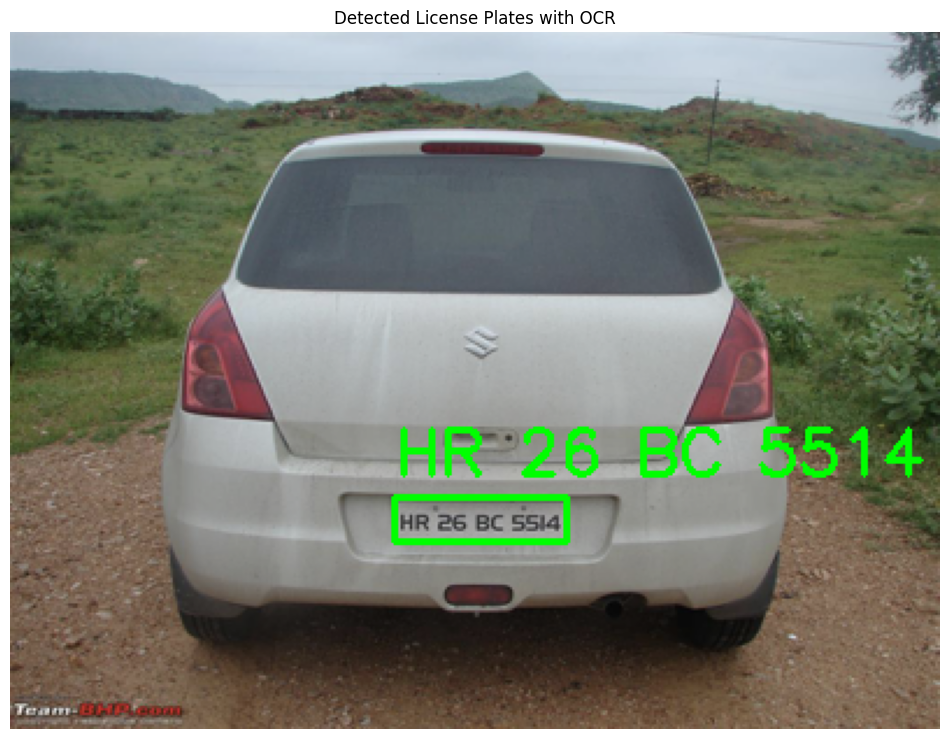

Detected License Plate Texts:
Plate 1: HR 26 BC 5514


In [13]:

# Perform inference on a test image
test_image_path = "/content/drive/MyDrive/Colab Datasets/archive/images/Cars24.png"
results = model(test_image_path, conf=0.25)

# Initialize Tesseract OCR
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

# Load and annotate the image
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

detected_boxes = results[0].boxes.xyxy.cpu().numpy()  # YOLO bounding boxes
texts = []

for i, box in enumerate(detected_boxes):
    x_min, y_min, x_max, y_max = map(int, box)
    cropped_plate = image_rgb[y_min:y_max, x_min:x_max]

    # Apply OCR
    ocr_result = pytesseract.image_to_string(cropped_plate, config="--psm 7")
    texts.append(ocr_result.strip())

    # Annotate the image
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(image, ocr_result.strip(), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display annotated image
annotated_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(annotated_image_rgb)
plt.axis("off")
plt.title("Detected License Plates with OCR")
plt.show()

# Print detected texts
print("Detected License Plate Texts:")
for i, text in enumerate(texts):
    print(f"Plate {i+1}: {text}")
